In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import viz

from matplotlib.ticker import FuncFormatter
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from scipy.stats import linregress

colors = viz.plotting_style()
lin_colors = list(colors.values())

plt.style.use('style.mpl')

In [2]:
# Load E. coli growth rates from Schmidt et al. 2016
coli_data = pd.read_csv('../data/proteomes/Coli/Chure_proteome_NOSC.csv')
mask = np.logical_and(
    coli_data.dataset.str.contains('schmidt'),
    coli_data.growth_mode != 'chemostat') 
stress_conds = 'pH6,osmotic_stress_glucose,42C'.split(',')
mask = np.logical_and(mask, ~coli_data.condition.isin(stress_conds))
coli_csource_df = coli_data[mask].sort_values('growth_rate_hr')
coli_csource_df.condition.replace({'glycerol_pAA': 'glycerol + AA', 'lb_miller': 'rich (LB)'}, inplace=True)

In [3]:
# Chemostat example. Maximum growth rate exists.
kayser_chemostat_df = pd.read_csv('../data/chemostat_data/kayser_chemostat_growth_unit_conv.csv')

# Metabolic modes of E. coli
coli_modes_df = pd.read_excel('../data/physiology/coli_metabolic_modes.xlsx', index_col=0)

# Load biomass macromolecular composition from Bremer & Dennis 2008
biomass_percent_df = pd.read_csv('../data/physiology/BremerDennis2008_BiomassComposition_pct.csv', index_col=0)

In [4]:
# Load model sensitivity analyses
phi_df = pd.read_csv('../output/Fig2A_variable_lambda.csv')
zcorg_sensitivity_df = pd.read_csv('../output/Fig2B_variable_ZCred.csv')

0.0001
estimated lambda_max: 2.592
actual lambda_max: 2.287042625886344


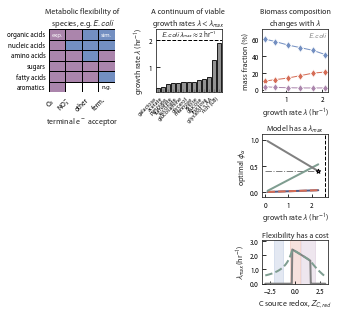

In [5]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(4.76, 4.5), 
                        gridspec_kw={'width_ratios': [1, 1, 1],
                                     'height_ratios': [1, 1, 0.7]})

for i in range(1,3):
    for j in range(0,2):
        plt.sca(axs[i, j])
        plt.axis('off')
        
# Panel on range of metabolic modes. 
plt.sca(axs[0,0])
coli_modes_num = coli_modes_df.replace(
    {'experiment': 3, 'engineered': 2, 'model': 1, np.NAN: 0})
cmap = ['w'] + [colors[x] for x in 'blue,green,purple'.split(',')]
sns.heatmap(coli_modes_num, cmap=cmap, cbar=False, linewidths=0.5, linecolor='black')
plt.ylabel('')
plt.xlabel('')
tick_labels = {
    'CO2': 'CO$_2$',
    'O2': 'O$_2$', 
    'NO3': 'NO$_3^{-}$',
    'DMSO/TMAO': 'other',
    'fermentation': 'ferm.'}
my_ticks = [tick_labels[x] for x in coli_modes_num.columns]
plt.xticks(np.arange(len(my_ticks))+0.5, my_ticks, rotation=45, ha='right')
plt.title('Metabolic flexibility of\n species, e.g. $E. coli$')
plt.text(0.5, 0.5, 'exp.', ha='center', va='center', fontsize=6.5, color='w')
plt.text(3.5, 0.5, 'sim.', ha='center', va='center', fontsize=6.5, color='w')
plt.text(3.5, 5.5, 'n.g.', ha='center', va='center', fontsize=6.5, color='k')
plt.tick_params(axis=u'both', which=u'both', length=0)
plt.xlabel('terminal e$^-$ acceptor')

# Panel on maximum growth rate -- E. coli growth rates by C-source from Schmidt 2016.
plt.sca(axs[0,1])
sns.barplot(data=coli_csource_df, y='growth_rate_hr', x='condition', color='grey',
            alpha=0.85, edgecolor='k', lw=1)
plt.axhline(2.0, color='k', ls='--', lw=1)
plt.xticks(rotation=45, ha='right', fontsize=6)
plt.ylim(0.1, 2.4)
plt.title('A continuum of viable \ngrowth rates $\lambda < \lambda_{max}$')
plt.text(6, 2.03, '$E. coli$ $\lambda_{max} \\approx 2$ hr$^{-1}$', va='bottom', ha='center', fontsize=7)

plt.ylabel('growth rate $\lambda$ (hr$^{-1}$)')
plt.xlabel('')

plt.sca(axs[0, 2])
labels = 'protein,RNA,DNA'.split(',')
keys = ['{0}_percent'.format(l) for l in labels]

# Plot the fractional composition of biomass.
pal = [colors[cid] for cid in "blue,red,purple".split(",")]
for l,k,c in zip(labels, keys, pal):  
    ys = biomass_percent_df[k]
    plt.plot(biomass_percent_df.growth_rate_hr, ys, marker='d', label=l,
             markersize=6, markeredgecolor='w', lw=1, color=c)

plt.xlabel('growth rate $\lambda$ (hr$^{-1}$)')
plt.ylabel('mass fraction (%)')
plt.title('Biomass composition\nchanges with $\lambda$')
plt.tick_params(axis='both')
plt.legend(loc=1).set_visible(False)
plt.ylim(-3, 72)
plt.text(0.99, 0.98, '$E. coli$', transform=plt.gca().transAxes, ha='right', va='top',
         fontsize=7, color='grey')

# Panels deriving from new model.
plt.sca(axs[1,2])

# Estimate lambda_max from simple relationships
min_phi_O = 0.4
g_ana = phi_df.anabolism_gamma.values[0]
print(g_ana)
est_lambda_max = 12*3600*g_ana*(1-min_phi_O)
lambda_max = phi_df.lambda_hr.max()
print('estimated lambda_max:', est_lambda_max)
print('actual lambda_max:', lambda_max)

# Line at min_phi_O
min_phi_O = 0.4
plt.plot([0, lambda_max], [min_phi_O, min_phi_O], 
         color='grey', ls='-.', lw=1)
#plt.text(1.1, min_phi_O+0.03, r'min. $\phi_O$', ha='center', fontsize=9)

x = phi_df['lambda_hr']
# Not plotting homeostasis because it was set to zero
cmap = dict(oxidation=colors['dark_blue'],
            reduction=colors['red'],
            anabolism=colors['dark_green'],
            other='grey')
processes = 'oxidation,reduction,anabolism'.split(',')
process_labels = dict(
    oxidation=r'$\phi_{ox}$',
    reduction=r'$\phi_{red}$',
    anabolism=r'$\phi_{ana}$',
    other=r'$\phi_O$')
phi_cols = ['{}_phi'.format(p) for p in processes] + ['phi_O']
for i, col in enumerate(phi_cols):
    label = processes[i] if i < len(processes) else r'other'
    legend_label = process_labels[label]
    c = cmap[label]
    ls = '--' if label == 'reduction' else '-'
    plt.plot(x, phi_df[col], label=legend_label, color=c, ls=ls)
plt.scatter([lambda_max], [min_phi_O], color=colors['purple'], edgecolor='k', marker='*', zorder=10, s=20)

plt.axvline(est_lambda_max, color='k', ls='--', lw=1) 
#plt.text(est_lambda_max-0.02, 0.3, r'$\lambda_{max} \approx \gamma_{ana}(1-\phi_O)$', ha='right', va='center', rotation=90, fontsize=9)
plt.xlabel(r'growth rate $\lambda$ (hr$^{-1}$)')
plt.ylabel(r'optimal $\phi_\alpha$')   
#plt.legend(loc=1)
plt.ylim(-0.1, 1.1)

plt.sca(axs[2,2])
phi_H_included = zcorg_sensitivity_df[
    zcorg_sensitivity_df['opt.max_phi_H_set'] == False]
no_phi_H = zcorg_sensitivity_df[
    zcorg_sensitivity_df['opt.max_phi_H_set'] == True]

plt.plot(no_phi_H.ZCorg, no_phi_H.lambda_hr, color='grey',
         label=r'baseline model'.format(min_phi_O))
plt.plot(phi_H_included.ZCorg, phi_H_included.lambda_hr,
         color=colors['dark_green'], ls='--',
         label=r'+ATP homeostasis', zorder=10)

plt.axvspan(-2.1, -1.2, color=colors['blue'], alpha=0.2, zorder=-10)
plt.axvspan(-0.5, 0.5, color=colors['red'], alpha=0.2, zorder=-10)
plt.axvspan(0.6, 2, color=colors['purple'], alpha=0.2, zorder=-10)

#plt.legend(loc=1)
plt.ylim(0, 3.1)
plt.xlabel('C source redox, $Z_{C,red}$')
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.yticks(np.arange(0, 3.1, 1))
plt.ylabel(r'$\lambda_{max}$ (hr$^{-1}$)')

titles = [
    'Model has a $\lambda_{max}$',
    'Flexibility has a cost',
]
for title, ax in zip(titles, axs[1:,-1]):
    ax.set_title(title)
  
plt.tight_layout(h_pad=0.2)
plt.subplots_adjust(hspace=0.75)
plt.savefig('../output/Fig1.png', facecolor='white', dpi=300)
plt.show()

In [6]:
mask = np.logical_and(kayser_chemostat_df.D_per_h.notnull(),
                      kayser_chemostat_df.r_glucose_mmol_g_h.notnull())
masked_kayser = kayser_chemostat_df[mask]
kayser_regression = linregress(masked_kayser.D_per_h, masked_kayser.r_glucose_mmol_g_h)
kayser_regression

LinregressResult(slope=9.330509186719699, intercept=0.16059826890195206, rvalue=0.9960383317181503, pvalue=6.487887131442609e-13, stderr=0.2511634516689206, intercept_stderr=0.0669850545879041)

Text(0.5, 1.0, 'A continuum of viable \ngrowth rates $\\lambda < \\lambda_{max}$')

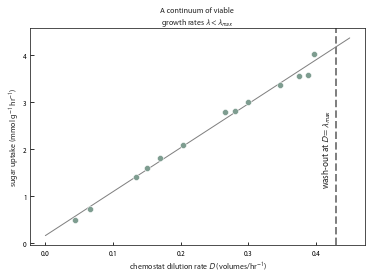

In [7]:
sns.scatterplot(data=kayser_chemostat_df, x='D_per_h', y='r_glucose_mmol_g_h', color=colors['dark_green'])

# Plot a regression
Ds = np.arange(0, masked_kayser.D_per_h.max()+0.1, 0.05)
pred_uptake = kayser_regression.slope*Ds + kayser_regression.intercept
plt.plot(Ds, pred_uptake, ls='-', lw=1, color='grey', zorder=-1)

plt.ylabel('sugar uptake (mmol g$^{-1}$ hr$^{-1}$)')
plt.xlabel('chemostat dilution rate $D$ (volumes/hr$^{-1}$)')

plt.axvline(0.43, color='grey', ls='--')
plt.text(0.417, 2, 'wash-out at $D = \lambda_{max}$', va='center', ha='center', rotation=90, fontsize=9)
plt.title('A continuum of viable \ngrowth rates $\lambda < \lambda_{max}$')

In [8]:

var_phi_O_df = pd.read_csv('../output/Fig2S1_variable_phi_O.csv')
var_phi_red_df = pd.read_csv('../output/Fig2S1_variable_phi_red.csv')
var_g_ana_df = pd.read_csv('../output/Fig2S1_variable_g_ana.csv')
var_g_red_df = pd.read_csv('../output/Fig2S1_variable_g_red.csv')


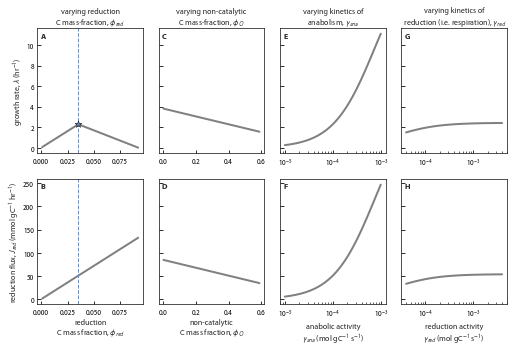

In [9]:
# Supplementary figure focusing on respiratory rates
# TODO: add variable stoichiometry, e.g. S4, to these panels
# TODO: calculate CUE and plot that as well
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(7.24, 5), sharey='row')
flat_axs = axs.flatten(order='F')

# Left panel: varying phi_red
# Model can use ATP homeostasis to maximize growth
plt.sca(axs[0,0])
max_idx = var_phi_red_df.lambda_hr.idxmax()
plt.plot(var_phi_red_df.reduction_phi, var_phi_red_df.lambda_hr, color='grey')
plt.scatter(var_phi_red_df.reduction_phi[max_idx], var_phi_red_df.lambda_hr[max_idx],
            color=colors['blue'], marker='*', zorder=10, s=50, edgecolor='k', lw=0.5)
plt.axvline(var_phi_red_df.reduction_phi[max_idx], color=colors['blue'], ls='--', lw=1)
plt.ylabel(r'growth rate, $\lambda$ (hr$^{-1}$)')
plt.title('varying reduction\nC mass-fraction, $\phi_{red}$')
plt.sca(axs[1,0])
plt.plot(var_phi_red_df.reduction_phi, var_phi_red_df.reduction_flux*3.6e6,
         color='grey')
plt.axvline(var_phi_red_df.reduction_phi[max_idx], color=colors['blue'], ls='--', lw=1)
plt.ylabel(r'reduction flux, $J_{red}$ (mmol gC$^{-1}$ hr$^{-1}$)')
plt.xlabel('reduction\nC mass fraction, $\phi_{red}$')

# Left panel: varying phi_O
# Model can use ATP homeostasis to maximize growth
plt.sca(axs[0,1])
plt.plot(var_phi_O_df.phi_O, var_phi_O_df.lambda_hr, color='grey', label=r'$\phi_O \geq$ {0:.1f}'.format(min_phi_O))
plt.title('varying non-catalytic\nC mass-fraction, $\phi_O$')
plt.sca(axs[1,1])
plt.plot(var_phi_O_df.phi_O, var_phi_O_df.reduction_flux*3.6e6, color='grey', label=r'$\phi_O \geq$ {0:.1f}'.format(min_phi_O))
plt.xlabel('non-catalytic\nC mass fraction, $\phi_O$')

# Middle panels: varying anabolism gamma
# TODO: narrow range here so growth rates don't balloon as much
mask = var_g_ana_df['opt.max_phi_H_set'] == False
masked = var_g_ana_df[mask]

plt.sca(axs[0,2])
plt.xscale('log')
plt.plot(masked.anabolism_gamma, masked.lambda_hr, color='grey', label=r'$\phi_O \geq$ {0:.1f}'.format(min_phi_O))
plt.title('varying kinetics of\nanabolism, $\gamma_{ana}$')
plt.sca(axs[1,2])
plt.xscale('log')
plt.plot(masked.anabolism_gamma, masked.reduction_flux*3.6e6, color='grey', label=r'$\phi_O \geq$ {0:.1f}'.format(min_phi_O))
plt.xlabel('anabolic activity\n$\gamma_{ana}$ (mol gC$^{-1}$ s$^{-1}$)')

# Right panels: varying anabolism gamma
mask = var_g_red_df['opt.max_phi_H_set'] == False
masked = var_g_red_df[mask]

plt.sca(axs[0, 3])
plt.xscale('log')
plt.plot(masked.reduction_gamma, masked.lambda_hr, color='grey', label=r'$\phi_O \geq$ {0:.1f}'.format(min_phi_O))
plt.title('varying kinetics of\n reduction (i.e. respiration), $\gamma_{red}$')
plt.sca(axs[1, 3])
plt.xscale('log')
plt.plot(masked.reduction_gamma, masked.reduction_flux*3.6e6, color='grey', label=r'$\phi_O \geq$ {0:.1f}'.format(min_phi_O))
plt.xlabel('reduction activity\n$\gamma_{red}$ (mol gC$^{-1}$ s$^{-1}$)')

for label, ax in zip("ABCDEFGH", flat_axs):
    ax.text(0.03, 0.97, label, transform=ax.transAxes, fontsize=8, fontweight='bold', va='top')

plt.tight_layout()
plt.savefig('../output/FigSX_max_Jred.png', facecolor='white', bbox_inches='tight', dpi=300)

In [10]:
var_S4_df = pd.read_csv('../output/Fig3A_variable_ZCorg_var_S4.csv')
var_S3_df = pd.read_csv('../output/Fig3B_variable_ZCorg_var_S3.csv')
var_ZCB_df = pd.read_csv('../output/Fig3C_variable_ZCorg_var_ZCB.csv')

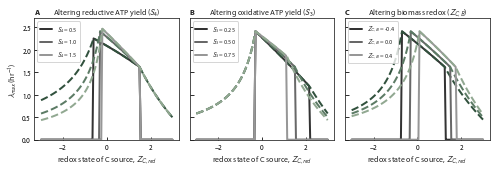

In [11]:
# Notice that phi_O increases as lambda decreases
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(7, 2.5), sharey=True)
pal = sns.color_palette('Greys_r', n_colors=5)
greens = sns.color_palette('Greens_r', n_colors=5, desat=0.3)
flat_axs = axs.flatten()

# Variable S4 = respiratory ATP yield
plt.sca(axs[0])
plt.title('Altering reductive ATP yield ($S_4$)')

my_S4s = [0.5, 1, 1.5]
for i, S4 in enumerate(my_S4s):
    masked = var_S4_df[var_S4_df['S4'] == S4]

    phi_H_included = masked[
        masked['opt.max_phi_H_set'] == False]
    no_phi_H = masked[
        masked['opt.max_phi_H_set'] == True]
    plt.plot(no_phi_H.ZCorg, no_phi_H.lambda_hr, color=pal[i], label='$S_4$ = {0:.1f}'.format(S4))
    plt.plot(phi_H_included.ZCorg, phi_H_included.lambda_hr, color=greens[i], ls='--')

plt.ylabel('$\lambda_{max}$ (hr$^{-1}$)')
plt.xlabel('redox state of C source, $Z_{C,red}$')
plt.legend(loc=2)

# Variable S3 = oxidative ATP yield
plt.sca(axs[1])
plt.title('Altering oxidative ATP yield ($S_3$)')

my_S3s = [0.25, 0.5, 0.75]
for i, S3 in enumerate(my_S3s):
    masked = var_S3_df[var_S3_df['S3'] == S3]

    phi_H_included = masked[
        masked['opt.max_phi_H_set'] == False]
    no_phi_H = masked[
        masked['opt.max_phi_H_set'] == True]
    plt.plot(no_phi_H.ZCorg, no_phi_H.lambda_hr, color=pal[i], label='$S_3$ = {0:.2f}'.format(S3+0))
    plt.plot(phi_H_included.ZCorg, phi_H_included.lambda_hr, color=greens[i], ls='--')

plt.xlabel('redox state of C source, $Z_{C,red}$')
plt.legend(loc=2)

# Variable ZCB
plt.sca(axs[2])
plt.title('Altering biomass redox ($Z_{C,B}$)')

ZCBs = np.array(sorted(var_ZCB_df.ZCB.unique()))
my_ZCBs = ZCBs[[ 1, 5, 9, ]]
for i, zcb in enumerate(my_ZCBs):
    mask = var_ZCB_df['ZCB'] == zcb
    masked = var_ZCB_df[mask]

    phi_H_included = masked[
        masked['opt.max_phi_H_set'] == False]
    no_phi_H = masked[
        masked['opt.max_phi_H_set'] == True]
    plt.plot(no_phi_H.ZCorg, no_phi_H.lambda_hr, color=pal[i], label='$Z_{{C,B}}$ = {0:.1f}'.format(zcb+1e-6))
    plt.plot(phi_H_included.ZCorg, phi_H_included.lambda_hr, color=greens[i], ls='--')

plt.legend(loc=2) 
plt.xlabel('redox state of C source, $Z_{C,red}$')  
plt.ylim(0, 2.7)

for label, ax in zip("ABCDEFGH", flat_axs):
    plt.sca(ax)
    plt.title(label, loc='left', fontweight='bold')

plt.tight_layout()
plt.savefig('../output/FigSX_model_change_stoich.png', facecolor='white', bbox_inches='tight', dpi=300)
plt.show()

In [12]:
# Enzymology figures
enz_data = pd.read_csv('../data/enzymes/BarEven2011_compact_kinetics.csv')
enz_data.head(4)

,EC1,EC2,EC3,EC4,compound_ID,reaction_ID,direction,organism_ID,publication_ID,T,pH,KM_uM,kcat_s,module_ID,module_name,module_type
0,1,1,1,1,84,754,1,7,2819000,NaN,NaN,3400.0,NaN,NaN,NaN,NaN
1,1,1,1,1,84,754,1,7,6395900,NaN,NaN,85.0,NaN,NaN,NaN,NaN
2,1,1,1,1,84,754,1,8,6354100,NaN,NaN,217.0,NaN,NaN,NaN,NaN
3,1,1,1,1,84,754,1,9,3282500,NaN,NaN,2830.0,NaN,NaN,NaN,NaN


/var/folders/h9/fvnb4xnn63qg71jx6ncvg62w0000gn/T/ipykernel_68584/2191040141.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['log_KM_uM'] = np.log10(sub_df.KM_uM)
/opt/miniconda3/lib/python3.8/site-packages/seaborn/categorical.py:1136: UserWarning: You passed a edgecolor/edgecolors ('#000000') for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(cat_pos, strip_data, **kws)


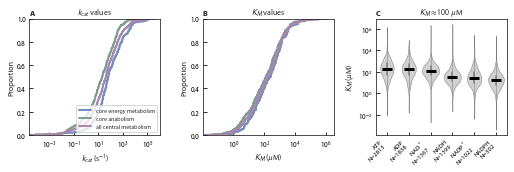

In [13]:
fig, axs = plt.subplots(ncols=3, figsize=(7.24, 2.5))
flat_axs = axs.flatten()

notnull = enz_data.kcat_s.notnull()
mask_primary_energy = np.logical_and(
    notnull, enz_data.module_type == 'Primary - Carbohydrate & Energy Metabolism')
mask_primary_biosyn = np.logical_and(
    notnull, enz_data.module_type == 'Primary - amino acids, fatty acids and nucleotides')
mask_primary_all = np.logical_or(mask_primary_energy, mask_primary_biosyn)
mask_secondary = np.logical_and(
    notnull, enz_data.module_type == 'Secondary')

sub_dfs = [enz_data[mask] for mask in [mask_primary_energy, mask_primary_biosyn, mask_primary_all]]
names = ['core energy metabolsm', 'core anabolism', 'all central metabolism']

# kcat plot
plt.sca(axs[0])
plt.xscale('log')
my_pal = [colors['blue'], colors['dark_green'], colors['purple']]
for i, (df, name) in enumerate(zip(sub_dfs, names)):
    sns.ecdfplot(df.kcat_s, label=name, color=my_pal[i])
    plt.xlabel('$k_{cat}$ (s$^{-1}$)')
plt.legend(loc=4, fontsize=6)
plt.title('$k_{cat}$ values')

# KM plot
plt.sca(axs[1])
plt.xscale('log')
for i, (df, name) in enumerate(zip(sub_dfs, names)):
    sns.ecdfplot(df.KM_uM, label=name, color=my_pal[i])
    plt.xlabel('$K_{M}}$ ($\mu$M)')
plt.title('$K_M$ values')

plt.sca(axs[2])
cpds = {
    2: 'ATP',
    8: 'ADP',
    3: 'NAD$^+$',
    4: 'NADH',
    6: 'NADP$^+$',
    5: 'NADPH',
}
cpd_order = list(cpds.keys())
sub_df = enz_data[enz_data.compound_ID.isin(cpds.keys())]
sub_df['log_KM_uM'] = np.log10(sub_df.KM_uM)
counts = sub_df.groupby('compound_ID').agg({'KM_uM':'count'}).values.T[0].tolist()
medians = sub_df.groupby('compound_ID').agg({'KM_uM':'median', 'log_KM_uM':'median'})

@FuncFormatter
def my_formatter(x, pos):
     return r"10$^{{{0:0.0f}}}$".format(x)

greys = sns.color_palette('Greys', 6)
sns.violinplot(data=sub_df, x='compound_ID', y='log_KM_uM', marker='d', s=4, order=cpd_order, color=greys[1], edgecolor='k', linewidth=0.5, jitter=0.3)
sns.stripplot(data=medians, x=medians.index, y='log_KM_uM', marker='_', s=10, order=cpd_order, color='k', linewidth=3, jitter=0)

xs = np.arange(6)
labels = [cpds[i] for i in cpd_order]
labels = ['{0}\nN={1}'.format(l, n) for l,n in zip(labels, counts)]
plt.xticks(xs, labels, fontsize=6.5, rotation=45, ha='right')
plt.xlabel('')
plt.ylabel('$K_M$ ($\mu$M)')
plt.gca().yaxis.set_major_formatter(my_formatter)

plt.title('$K_M \\approx 100$ $\\mu$M')

for label, ax in zip("ABCDEFGH", flat_axs):
    plt.sca(ax)
    plt.title(label, loc='left', fontweight='bold')

plt.tight_layout()
plt.savefig('../output/FigSX_enzyme_kinetics.png', facecolor='white', bbox_inches='tight', dpi=300)
plt.show()